In [1]:
import urllib, urllib.request    
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
from requests.adapters import TimeoutSauce
from datetime import datetime
import os
import feedparser
try:
    from urllib.request import urlopen
except ImportError:
    from urllib2 import urlopen
import PyPDF2
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import pickle
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nick\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nick\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
class predict_paper_relevance:
    def __init__(self, directory = ".//data//arxiv test//feb//", doc2vec_path=".//models//doc2vec//model_dbow_vs_600_n_5_s_0.bin", classifier_path=".//models//classifiers//lr.sav"):
        self.directory = directory
        self.files = os.listdir(directory)
        
        self.doc2vec_model = Doc2Vec.load(doc2vec_path)
        self.classifier = pickle.load(open(classifier_path, 'rb'))
        
    def download_pdfs(self, papers_list_filename):
        # extract paper codes (eg arXiv:2302.12897) from astro-ph emails, save in papers_list_filename
        headers = {
            'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.111 Safari/537.36',
        }
        session = requests.Session()
        retry = Retry(connect=3, backoff_factor=10)
        adapter = HTTPAdapter(max_retries=retry)
        session.mount('http://', adapter)
        session.mount('https://', adapter)
        
        pdf_links = []
        with open(f'{directory}{papers_list_filename}', 'r') as f:
            for line in f:
                # line looks like this: arXiv:2302.12897
                # corrupt files come from 'access denied' issue
                # adding 'export' to the url fixes it
                pdf_url = f"http://export.arxiv.org/pdf/{line.strip()[6:]}"
                pdf_links.append(pdf_url)

        for link in pdf_links:
            if f"{pdf_url[28:]}.pdf" in files:
                file_size = os.path.getsize(f'{self.directory}{link[28:]}.pdf')
                if file_size < 80000:
                    pass
                else:
                    continue

            response = session.get(link, headers=headers)
            with open(f'{directory}{link[28:]}.pdf', 'wb') as f:
                f.write(response.content)
                

    def tokenize_text(self, text):
        stopWords = set(stopwords.words('english'))

        tokens = []
        for sentence in nltk.sent_tokenize(text):
            for word in nltk.word_tokenize(sentence):
                if len(word) < 2 or word in stopWords:
                    continue
                tokens.append(word.lower())
        return tokens
    
    def predict_multiple_paper_relevance(self, file_list):
#         paper_texts = []
        try:
            X = np.load(self.directory + "feb_inferred_vectors.npy")
            good_papers = np.load(self.directory + "feb_good_papers.npy")
        except:
            print("Reading PDFs and inferring vectors...")
            bad_papers = []
            good_papers = []
            paper_texts = []
            for filename in file_list: 
                # filename looks like this 1202.5809.pdf
                if ("pdf" not in filename) or (filename in bad_papers):
                    continue

                try:
                    reader = PyPDF2.PdfReader(self.directory+filename) # EOF error when file is corrupt
                except:
                    if filename not in bad_papers:
                        bad_papers.append(filename)
                    continue

                paper_text = ""
                paper_good = True
                for page in reader.pages:
                    if not paper_good:
                        continue

                    try:
                        text = page.extract_text() # grabs file name if text is nonselectable
                    except:
                        paper_good = False
                        if filename not in bad_papers:
                            bad_papers.append(filename)
                        continue

    #                 if text in filename: # triggers when the pdf contains a blank page (4 in feb set), change in future versions of Convert PDFs to Test notebook (ie future re-training)
    #                     paper_good = False
    #                     if filename not in bad_papers:
    #                         bad_papers.append(filename)
    #                     continue

                    paper_text += text

                if len(paper_text) > 1000:
                    paper_text = paper_text.replace('\n', '').replace("\r", "")
                    for punct in string.punctuation:
                        paper_text = paper_text.replace(punct, "")
                    good_papers.append(filename)
                    paper_texts.append(paper_text)
                else:
                    paper_good = False
                    if filename not in bad_papers:
                        bad_papers.append(filename)
                    continue 

            X = [self.doc2vec_model.infer_vector(self.tokenize_text(paper_text)) for paper_text in paper_texts]
            np.save(self.directory + "feb_inferred_vectors.npy", X)
            np.save(self.directory + "feb_good_papers.npy", np.array(good_papers))

        probs = self.classifier.predict_proba(X) # need this if inferring one at a time: X.reshape(1, -1) also [0] at end
#         ea_probs.append(probs[1])
        ea_probs = [prob[1] for prob in probs]

        return ea_probs, good_papers#, bad_papers

In [40]:
predictor = predict_paper_relevance()
directory = ".//data//arxiv test//feb//"
files = np.unique(os.listdir(directory))
start = time.time()
ea_probs, good_papers = predictor.predict_multiple_paper_relevance(files)
duration = time.time() - start
print(duration)
# took about 4 hours inferring indiviudal files
# took 2.6 hours with vectorized inference

0.04400038719177246


In [17]:
pos_papers = []
with open('.//data//arxiv test//feb//pos_papers_list.txt', 'r') as f:
    for line in f:
        pos_papers.append(line.strip()) # looks like '2301.13260'

pos_papers = np.unique(pos_papers)
print(len(np.unique(pos_papers)))
# 45 papers determined to be relevant by scientists

45


In [9]:
other_pos_papers = []
for id_ in np.unique(pos_papers):
    if id_ not in results_df["paper"].values:
        other_pos_papers.append(id_)
        
print(len(other_pos_papers))
# all positive papers are present in set

NameError: name 'results_df' is not defined

In [21]:
len(good_papers)

1743

In [41]:
results_df = pd.DataFrame({"paper":[p[:-4] for p in good_papers], "ea prob":ea_probs})

results_df["true label"] = np.repeat(0, len(good_papers))
results_df["predicted label"] = np.repeat(0, len(good_papers))
relevant_inds = results_df[results_df["ea prob"] > 0.5].index.values
results_df.loc[relevant_inds, "predicted label"] = 1

pos_paper_inds = results_df[results_df['paper'].isin(pos_papers)].index.values
results_df.loc[pos_paper_inds, "true label"] = 1

results_df.head()

,paper,ea prob,true label,predicted label
0,1202.5809,0.025227,0,0
1,1307.1705,0.025284,0,0
2,1505.02172,0.059849,0,0
3,1606.09199,0.043146,0,0
4,1803.00575,0.735074,0,1


In [45]:
results_df.to_csv("lr_feb_results.csv", index=False)

In [43]:
sum(results_df["true label"] == results_df["predicted label"])/len(results_df.index)
# 0.912794033275961 for svm
# 0.9001721170395869 for xgb
# 0.9036144578313253 for lr

0.9036144578313253

In [42]:
results_df[results_df['paper'].isin(pos_papers)]
# all positive papers were correctly labeled for svm
# all positive papers were correctly labeled for xgb
# all positive papers were correctly labeled for lr

,paper,ea prob,true label,predicted label
80,2203.16959,0.942181,1,1
120,2205.12162,0.930747,1,1
218,2209.00620,0.909916,1,1
252,2209.11160,0.990876,1,1
336,2210.11809,0.979699,1,1
356,2211.01474,0.970478,1,1
381,2211.06445,0.994882,1,1
459,2212.06266,0.973778,1,1
495,2301.02477,0.978578,1,1
562,2301.13260,0.806849,1,1


In [12]:
print(len(results_df))
print(len(results_df[results_df["ea prob"] > 0.5]))
# 1739 total papers, 196 potential relevant given 50% threshold

1743
197


In [13]:
# false positives
nonpos_papers = results_df[~results_df['paper'].isin(pos_papers)]
nonpos_papers[nonpos_papers["ea prob"] > 0.5].sort_values(by="ea prob", ascending=False)
# probability makes sense (top 5 could be relevant, bottom 5 are not)
# >50% classification cutoff could help

,paper,ea prob,true label,predicted label
72,2203.07178,0.999998,0,1
508,2301.04206,0.997221,0,1
850,2302.04138,0.996542,0,1
61,2201.09963,0.996533,0,1
1091,2302.06724,0.996373,0,1
...,...,...,...,...
1147,2302.07308,0.528634,0,1
1529,2302.11424,0.528517,0,1
1138,2302.07274,0.524727,0,1
669,2302.01949,0.516727,0,1


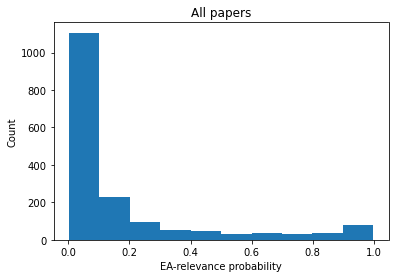

In [44]:
plt.hist(results_df["ea prob"])
plt.xlabel("EA-relevance probability")
plt.ylabel("Count")
plt.title("All papers")
plt.show()

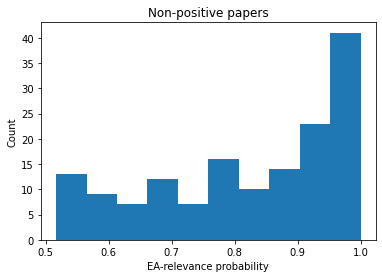

In [15]:
# nonpos papers are those in the feb set that weren't flagged by a scientist
nonpos_probs = nonpos_papers[nonpos_papers["ea prob"] > 0.5]["ea prob"].values
plt.hist(nonpos_probs)
plt.xlabel("EA-relevance probability")
plt.ylabel("Count")
plt.title("Non-positive papers")
plt.show() 

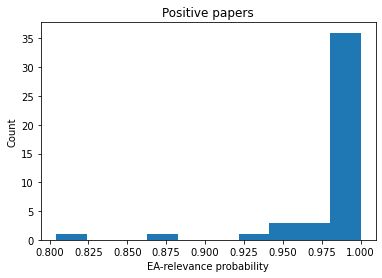

In [16]:
# pos papers in the feb data are those that were flagged by a scientist
pos_probs = results_df[results_df['paper'].isin(pos_papers)]["ea prob"].values
plt.hist(pos_probs)
plt.xlabel("EA-relevance probability")
plt.ylabel("Count")
plt.title("Positive papers")
plt.show()
# papers which are actually relevant have probability >80%
# papers with probability >80% are not necessarily relevant

In [17]:
bad_papers
# bad papers should be cleared by fix

[]